# IMPORTS (PYTHON)

In [1]:
import sys
import os
import pickle

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import math

from pathlib import Path
from importlib import reload

# PATHS

In [2]:
path_data = '/home/lemasle/PROJECTS/UCI_electricity_consumption/data/UC_Irvine_ML_repository/'
path_src = Path('./src')
sys.path.append(os.path.abspath(path_src))
path_figs = Path('./figs')

# IMPORT: MODULES

In [3]:
import files_io as files_io
import cleaning as cleaning
import explore_vis as explore_vis
import features as features
import feature_vis as feature_vis
import data_prep as data_prep
import models as models
import model_vis as model_vis

cm = 1/2.54

# IMPORT & CLEAN DATA

In [4]:
files_io.extract_zip(path_data, 'individual+household+electric+power+consumption.zip')
data = files_io.import_data_UCI(path_data, 'household_power_consumption.txt')
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [5]:
# 1.date: Date in format dd/mm/yyyy
# 2.time: time in format hh:mm:ss
# 3.global_active_power: household global minute-averaged active power (in kilowatt)
# 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
# 5.voltage: minute-averaged voltage (in volt)
# 6.global_intensity: household global minute-averaged current intensity (in ampere)
# 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
# 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
# 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [6]:
list_col = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', \
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

count, percent = cleaning.check_nans(data)

NULL VALUES PER COLUMN:
date                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
% OF NULL VALUES PER COLUMN:
date                     0.0
Global_active_power      1.3
Global_reactive_power    1.3
Voltage                  1.3
Global_intensity         1.3
Sub_metering_1           1.3
Sub_metering_2           1.3
Sub_metering_3           1.3
dtype: float64


### Replace NaNs with interpolated values

In [7]:
data = cleaning.interpolate_nans(data, list_col)

In [8]:
count, percent = cleaning.check_nans(data)

NULL VALUES PER COLUMN:
date                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
% OF NULL VALUES PER COLUMN:
date                     0.0
Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
dtype: float64


### FEATURE CREATION: Sub_metering_rest

#### Sub_metering_rest encmpasses the electricity consumption not taken into account by the sub-meters 1-3

In [9]:
features.create_rest_feature(data)

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,15.566667


In [10]:
# update list of cols:
list_col = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', \
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_rest']

# CREATE HOURLY/DAILY/MONTHLY dataframes

In [11]:
data_h = cleaning.get_data_hourly_averaged(data)
data_hcat = features.timestamps_as_categories(data_h)
data_hcat.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,dayofmonth,dayofyear,week,month,year
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,52.992593,5,Saturday,16,350,50,12,2006
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,36.953333,5,Saturday,16,350,50,12,2006
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,38.553889,5,Saturday,16,350,50,12,2006
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,37.692778,5,Saturday,16,350,50,12,2006
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778,5,Saturday,16,350,50,12,2006


In [12]:
data_d = cleaning.get_data_daily_averaged(data)
data_dcat = features.timestamps_as_categories(data_d)
data_dcat.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,dayofmonth,dayofyear,week,month,year
0,2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,37.073064,5,Saturday,16,350,50,12,2006
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,25.657407,6,Sunday,17,351,50,12,2006
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190,0,Monday,18,352,51,12,2006
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375,1,Tuesday,19,353,51,12,2006
4,2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,14.156111,2,Wednesday,20,354,51,12,2006


In [13]:
data_m = cleaning.get_data_monthly_averaged(data)
data_mcat = features.timestamps_as_categories(data_m)
data_mcat.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,dayofmonth,dayofyear,week,month,year
0,2006-12-31,1.901537,0.131400,241.440835,8.030969,1.251864,2.216312,7.409847,20.814259,6,Sunday,31,365,52,12,2006
1,2007-01-31,1.546085,0.132683,240.904831,6.547133,1.264180,1.775851,7.383759,15.344291,2,Wednesday,31,31,5,1,2007
2,2007-02-28,1.401165,0.113634,240.519177,5.914911,1.180159,1.602282,6.704067,13.866244,2,Wednesday,28,59,9,2,2007
3,2007-03-31,1.318606,0.114747,240.513524,5.572890,1.361313,2.346819,6.504503,11.764133,5,Saturday,31,90,13,3,2007
4,2007-04-30,0.856787,0.126467,239.127693,3.685574,0.974028,0.889282,4.386644,8.029823,0,Monday,30,120,18,4,2007


# DATA EXPLORATION

### Trends: hourly/daily/monthly global active power

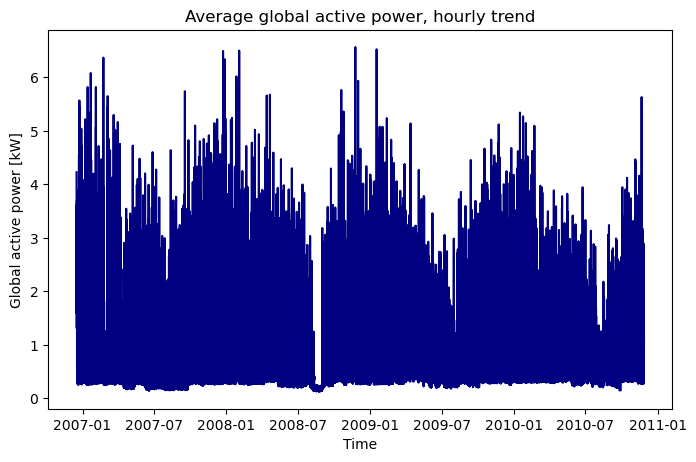

In [14]:
explore_vis.plot_trend(data_h, 'Global_active_power', 'Time', 'Global active power [kW]', \
                       'Average global active power, hourly trend', path_figs, 'UCI_hourly_averaged_trend', cm)

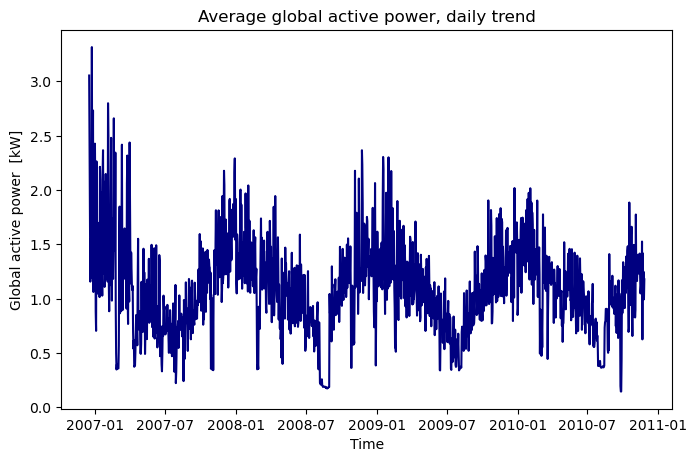

In [15]:
explore_vis.plot_trend(data_d, 'Global_active_power', 'Time', 'Global active power  [kW]', \
           'Average global active power, daily trend', path_figs, 'UCI_daily_averaged_trend', cm)

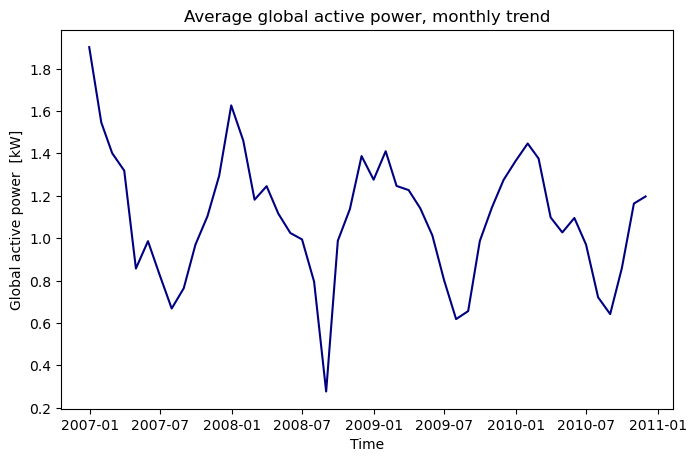

In [16]:
explore_vis.plot_trend(data_m, 'Global_active_power', 'Time', 'Global active power  [kW]', \
           'Average global active power, monthly trend', path_figs, 'UCI_monthly_averaged_trend', cm)

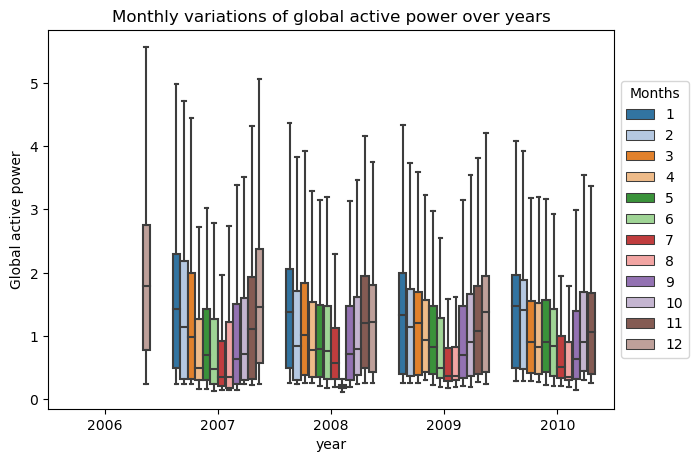

In [17]:
explore_vis.multiyear_boxplot(data_hcat, 'Global_active_power', 'month', r'year', r'Global active power', \
            r'Monthly variations of global active power over years', 'Months', path_figs, 'UCI_global_active_power_per_month_over_years.pdf', cm)

### Trends: monthly trends for sub-meters 1,2,3,rest

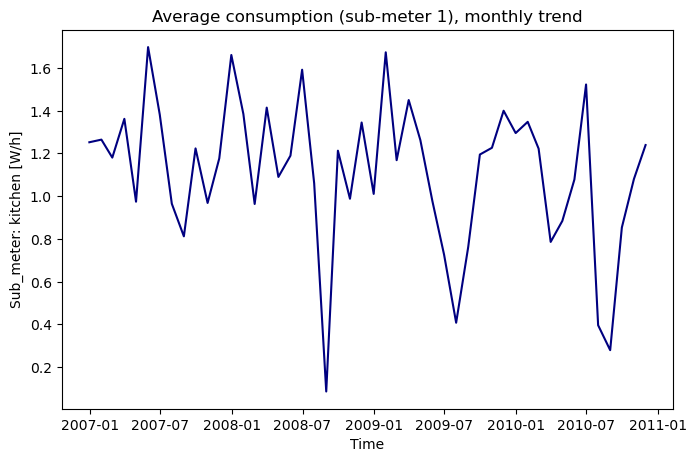

In [18]:
explore_vis.plot_trend(data_m, 'Sub_metering_1', 'Time', 'Sub_meter: kitchen [W/h]', \
           'Average consumption (sub-meter 1), monthly trend', path_figs, 'UCI_SM1_monthly_averaged_trend', cm)

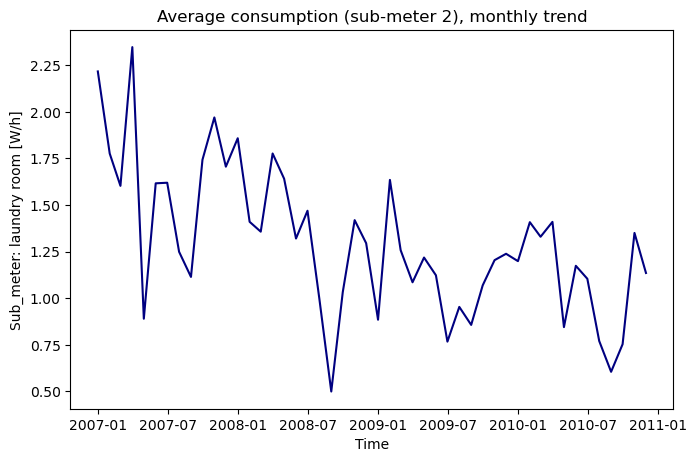

In [19]:
explore_vis.plot_trend(data_m, 'Sub_metering_2', 'Time', 'Sub_meter: laundry room [W/h]', \
           'Average consumption (sub-meter 2), monthly trend', path_figs, 'UCI_SM2_monthly_averaged_trend', cm)

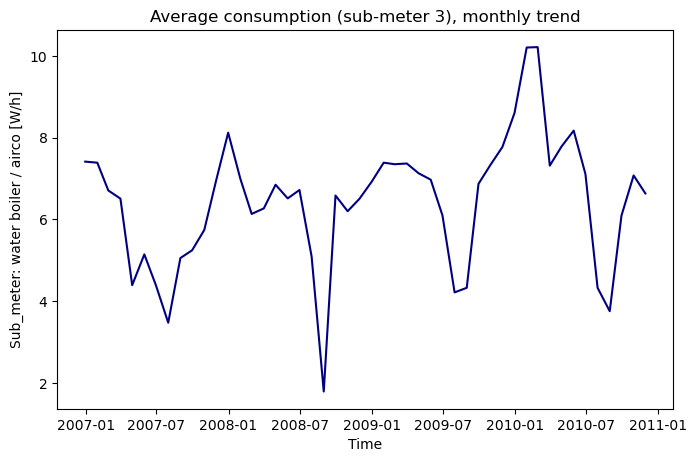

In [20]:
explore_vis.plot_trend(data_m, 'Sub_metering_3', 'Time', 'Sub_meter: water boiler / airco [W/h]', \
           'Average consumption (sub-meter 3), monthly trend', path_figs, 'UCI_SM3_monthly_averaged_trend', cm)

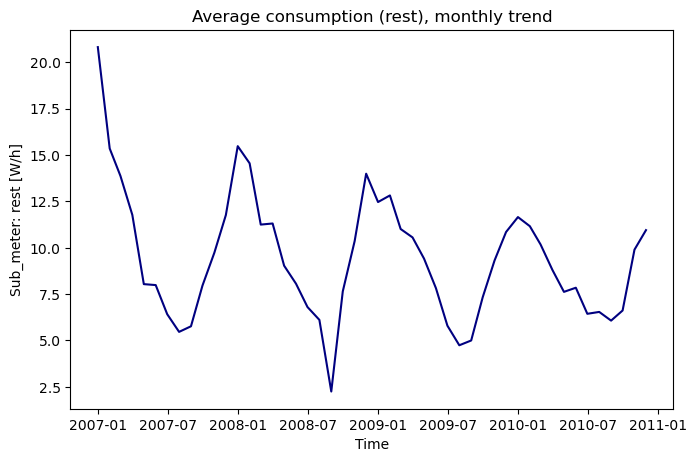

In [21]:
explore_vis.plot_trend(data_m, 'Sub_metering_rest', 'Time', 'Sub_meter: rest [W/h]', \
           'Average consumption (rest), monthly trend', path_figs, 'UCI_SM3_monthly_averaged_trend', cm)

### Global intensity: average values (per week / per day of the month)

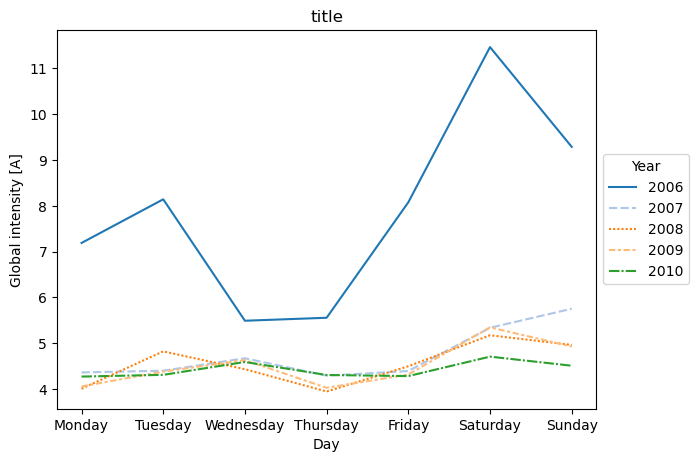

In [22]:
explore_vis.average_per_dayofweek_plot(data_hcat, 'year', 'Global_intensity', r'Day', r'Global intensity [A]', r'title', r'Year', \
                                       path_figs, 'UCI_average_of_the_global_intensity_per_dayofweek.pdf', cm)

### 2006 data only contains the last two weeks of December.

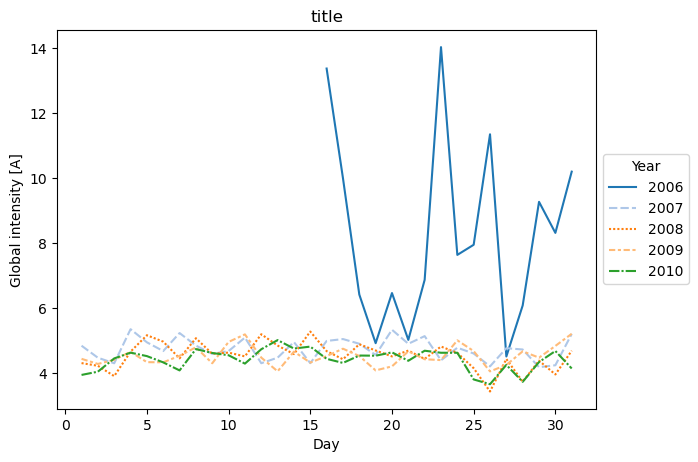

In [23]:
explore_vis.average_per_dayofmonth_plot(data_hcat, 'year', 'Global_intensity', r'Day', r'Global intensity [A]', r'title', r'Year', \
                              path_figs, 'UCI_average_of_the_global_intensity_per_dayofmonth.pdf', cm)

### Visualize multiple trends

In [24]:
data_beg2010 = data.set_index('date').loc['2010-01-15':'2010-01-20'].reset_index()

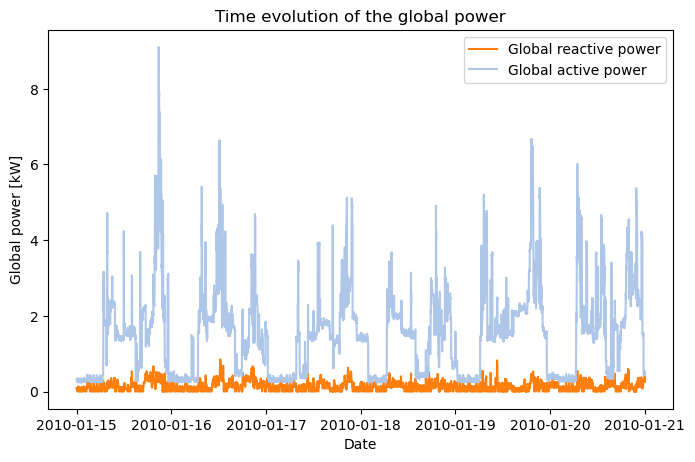

In [25]:
explore_vis.multi_trends(data_beg2010, ['Global_active_power', 'Global_reactive_power'], \
                         ['Global active power', 'Global reactive power'], r'Date', r'Global power [kW]', \
                         r'Time evolution of the global power', \
                         path_figs, 'Global_power_time_evolution.pdf', cm)

### DATA DISTRIBUTION PROFILES (hourly/daily data)

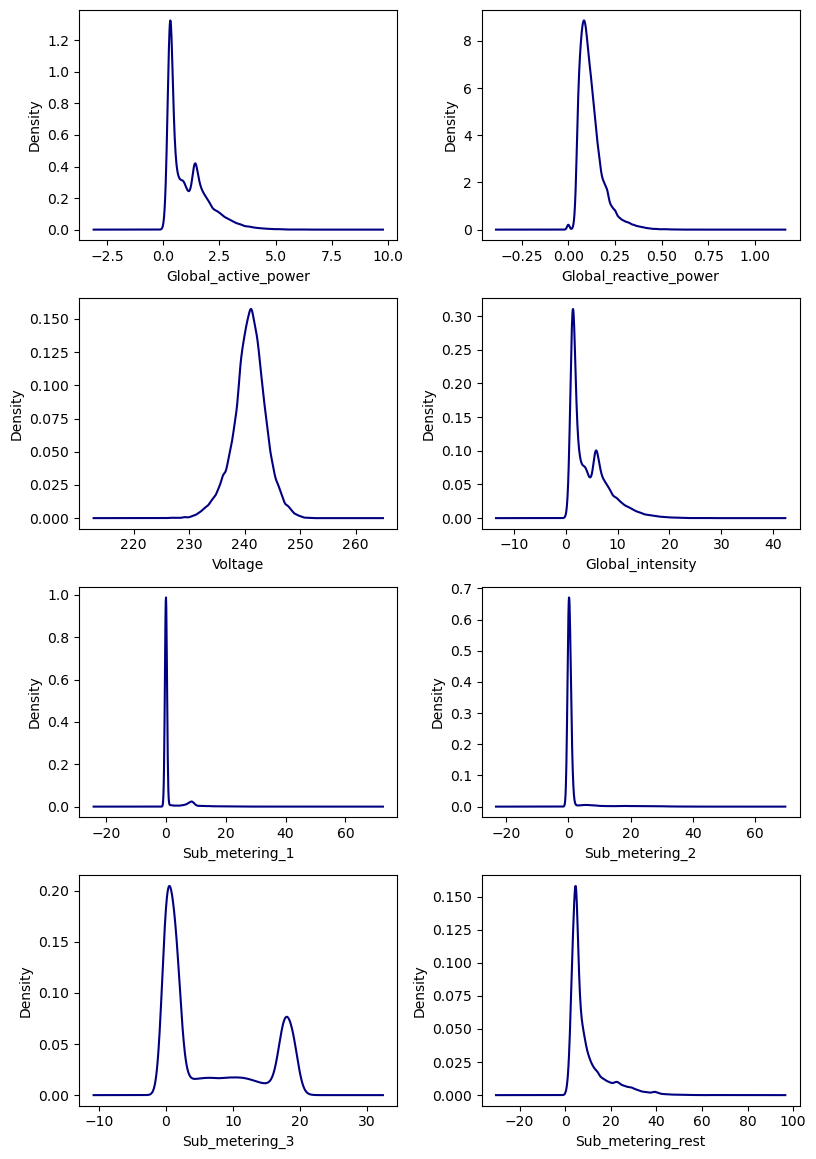

In [26]:
explore_vis.multiplot_density_distributions(data_h, list_col, path_figs, 'Density_distributions_hourly_data.pdf', cm)

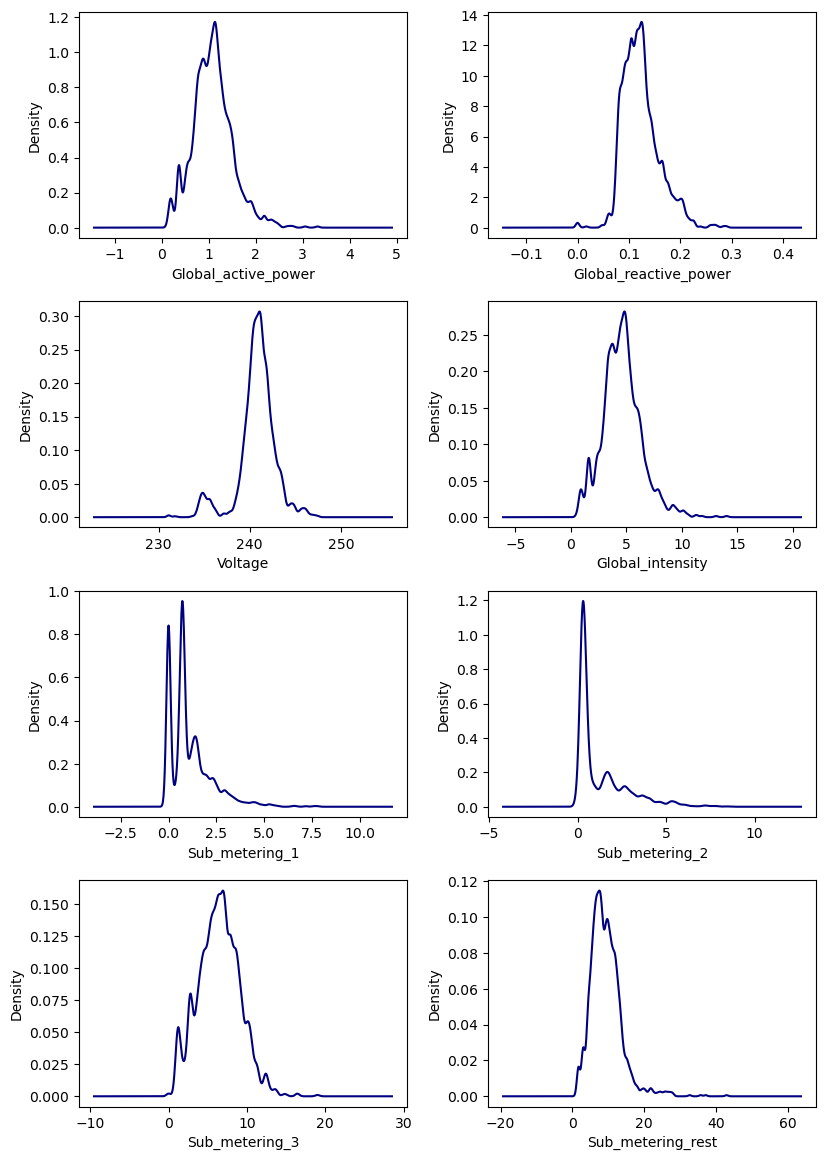

In [27]:
explore_vis.multiplot_density_distributions(data_d, list_col, path_figs, 'Density_distributions_daily_data.pdf', cm)

### In most cases: not Gaussian --> avoid feature selection methods that require Gaussian profile

# SPLIT TRAIN/TEST DATA

#### We use Jan-Nov 2010 as test data
#### And all the rest (Dec 2006 - dec D009) as train data

In [28]:
# hourly averaged data
train_h, test_h = data_prep.split_traintest_year(data_hcat)
print(len(train_h), len(test_h))

26671 7918


In [29]:
# daily averaged data
train_d, test_d = data_prep.split_traintest_year(data_dcat)
print(len(train_d), len(test_d))

1112 330


# LAG FEATURES

### PACF SELECTION OF LAG FEATURES 

In [30]:
lags_in_d = np.arange(31)
lags_in_h = np.arange(48)

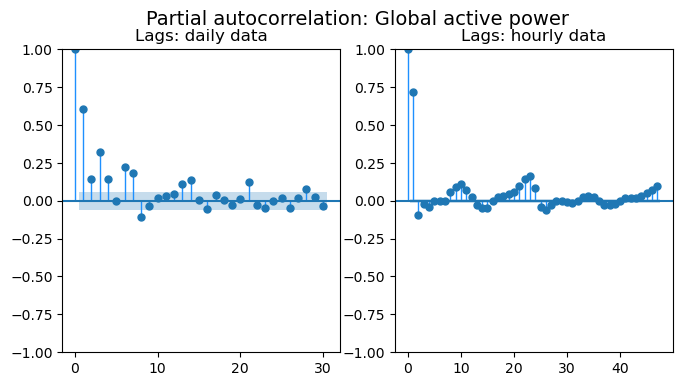

In [31]:
feature_vis.pacf_plot(train_d, train_h, 'Global_active_power', 'Global active power', 
                      lags_in_d, lags_in_h, path_figs, 'PACF_Global_active_power.pdf', cm)

In [32]:
pacf_d = features.get_lags_sorted_by_pacf(train_d.Global_active_power, nlags=366, alpha=0.05, threshold=0.1)
print('(Daily) features sorted by pacf:\n', pacf_d)

pacf_h = features.get_lags_sorted_by_pacf(train_h.Global_active_power, nlags=48, alpha=0.05, threshold=0.07)
print('(Hourly) features sorted by pacf:\n', pacf_h)

(Daily) features sorted by pacf:
        value  lag
1   0.607303    1
2   0.323961    3
3   0.223836    6
4   0.182430    7
5   0.146469    2
6   0.143454    4
7   0.138665   14
8   0.126896   21
9   0.114876   13
10  0.110222  364
11  0.106048   42
12  0.104883    8
(Hourly) features sorted by pacf:
        value  lag
1   0.719796    1
2   0.160734   23
3   0.141664   22
4   0.110566   10
5   0.099673   21
6   0.099096   47
7   0.092356    2
8   0.088350    9
9   0.084929   24
10  0.072318   46
11  0.072126   11


### CREATE LAG FEATURES

In [33]:
lag_list_d = pacf_d.lag.to_list()
#print(lag_list_d)
lag_list_h = pacf_h.lag.to_list()
#print(lag_list_h)

In [34]:
lag_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']

In [35]:
train_h = features.create_lag_features(train_h, lag_cols, lag_list_h)
test_h = features.create_lag_features(test_h, lag_cols, lag_list_h)

In [36]:
train_d = features.create_lag_features(train_d, lag_cols, lag_list_d)
test_d = features.create_lag_features(test_d, lag_cols, lag_list_d)

# RESCALE DATA

#### We remove categorical timestamps that were useful for exploration

In [37]:
timestamps_cols = ['day', 'dayname', 'dayofmonth', 'dayofyear', 'week', 'month', 'year']

In [38]:
# 'remove_timestamps' removes tiems stamps created for exploration
# and sets the 'date' column as dataframe index

train_h = data_prep.remove_timestamps(train_h, timestamps_cols)
test_h  = data_prep.remove_timestamps(test_h, timestamps_cols)
train_d = data_prep.remove_timestamps(train_d, timestamps_cols)
test_d  = data_prep.remove_timestamps(test_d, timestamps_cols)

In [39]:
# rescale_data
# - rescales data
# - backups the scaler as pickle
# - appends the rescaled data to the original train/test dataframes

In [40]:
train_h_sc = data_prep.rescale_data(train_h, 'robust_scaler', 'stdsc_trainh')
test_h_sc = data_prep.rescale_data(test_h, 'robust_scaler', 'stdsc_testh')

In [41]:
train_d_sc = data_prep.rescale_data(train_d, 'robust_scaler', 'stdsc_traind')
test_d_sc = data_prep.rescale_data(test_d, 'robust_scaler', 'stdsc_testd')

# SAVE DATA as CSV

In [42]:
data_prep.backup_csv(train_h_sc, path_data, 'hourly_scaled_train_data.csv')
data_prep.backup_csv(train_d_sc, path_data, 'daily_scaled_train_data.csv')
data_prep.backup_csv(test_h_sc, path_data, 'hourly_scaled_test_data.csv')
data_prep.backup_csv(test_d_sc, path_data, 'daily_scaled_test_data.csv')